In [26]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

#Read the csv file
df = pd.read_csv("upsample_min.csv")
df = pd.read_csv("upsample.csv")
df = pd.read_csv("upsampled_matlab.csv")
df2=df.drop(df.columns[0], axis=1)
data = df['glir11'].to_numpy()

split = 0.75

x1 = df['glir11'].to_numpy()[:int(split*len(data))]
x1 = x1.reshape(len(x1),1)
y1 = df['qt11'].to_numpy()[:int(split*len(data))]
y1 = y1.reshape(len(y1),1)

x2 = df['glir11'].to_numpy()[int(split*len(data)):]
y2 = df['qt11'].to_numpy()[int(split*len(data)):]

print(f"ukuran x train: {np.shape(x1)} ukuran y train: {np.shape(y1)}")
print(f"ukuran x test: {np.shape(x2)} ukuran y test: {np.shape(y2)}")

ukuran x train: (10725, 1) ukuran y train: (10725, 1)
ukuran x test: (3576,) ukuran y test: (3576,)


In [27]:
#New dataframe with only training data
df_for_training_x = x1
df_for_training_y = y1

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training_x)
scaler2 = scaler.fit(df_for_training_y)
df_for_training_scaled_x = scaler.transform(df_for_training_x)
df_for_training_scaled_y = scaler2.transform(df_for_training_y)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled_x) - n_future +1):
    trainX.append(df_for_training_scaled_x[i - n_past:i, 0:df_for_training_x.shape[1]])

for i in range(n_past, len(df_for_training_scaled_y) - n_future +1):
    trainY.append(df_for_training_scaled_y[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (10711, 14, 1).
trainY shape == (10711, 1).


In [28]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary("")


# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=15, validation_split=0.2, verbose=1)

#model.save("RNN_model")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 64)            16896     
                                                                 
 lstm_7 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 62,369
Trainable params: 62,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
572/572 [==============================

In [29]:
#model.save("RNN_model_renew")

In [30]:
layers = [0,1,2,4] #layer 0:lstm 1:lstm 3:dense

weights = {}
biases = {}
for layer in layers:
    weights[layer] = model.layers[layer].get_weights()[0]
    biases[layer] = model.layers[layer].get_weights()[1]

nlayer = 1
print(np.shape(weights[nlayer]))
print(weights[nlayer])

print(np.shape(biases[nlayer]))
print(biases[nlayer])

(64, 256)
[[-0.12869781 -0.04877257  0.11242637 ... -0.13475814 -0.1045298
   0.04105447]
 [-0.07072476 -0.14765291 -0.0011388  ... -0.14094082  0.07920077
  -0.02885665]
 [-0.01102272  0.02802884  0.04633651 ...  0.26172188  0.06206344
  -0.03783664]
 ...
 [-0.01588057 -0.14862256  0.03919037 ...  0.10730979 -0.15579979
  -0.08719243]
 [-0.05410681  0.11709672 -0.11950254 ...  0.1304511   0.1151084
  -0.00652784]
 [ 0.13404298  0.03862295  0.10839958 ...  0.00155733  0.0168882
   0.01977537]]
(64, 256)
[[-0.18546702 -0.03471137 -0.03391697 ...  0.09775281 -0.08430497
   0.01628273]
 [-0.00568683  0.01665159  0.07015236 ...  0.05287193  0.09133359
   0.06319687]
 [-0.22210789  0.07107069 -0.09875637 ... -0.07967871  0.05201021
   0.04206695]
 ...
 [-0.0832127  -0.01798232 -0.04139635 ...  0.003538    0.12480916
  -0.5074481 ]
 [ 0.05364762  0.05182012  0.06005337 ...  0.01000454  0.0062179
  -0.03376788]
 [-0.07009688  0.03657516 -0.00552146 ...  0.32033193  0.10825882
   0.03289253]]


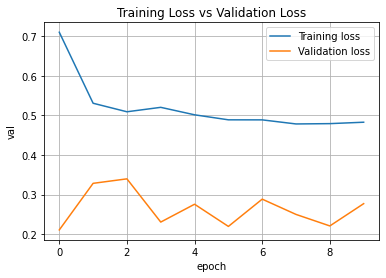

In [31]:
xx = np.arange(0,len(history.history['loss']))

"""print(history.history['loss'])
print(history.history['val_loss'])
print(xx)"""

plt.figure(1)
plt.plot(xx,history.history['loss'], label='Training loss')
plt.plot(xx,history.history['val_loss'], label='Validation loss')
plt.title("Training Loss vs Validation Loss")
plt.xlabel("epoch")
plt.ylabel("val")
plt.legend()
plt.grid()

335/335 [==============================] - 2s 4ms/step
nilai pred: [[213.8567 ]
 [213.8567 ]
 [213.8567 ]
 ...
 [430.95923]
 [430.95923]
 [430.95923]]
ukuran y: (10711, 1) ukuran y pred: (10711, 1)


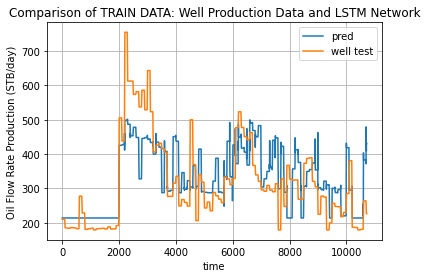

In [32]:
#Make prediction
#model = keras.models.load_model("RNN_Model")

n_days_for_prediction = 20
prediction = model.predict(trainX[:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range

prediction_copies = np.repeat(prediction, df_for_training_y.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)

print('nilai pred:',y_pred_future)

yy = scaler.inverse_transform(trainY)

x_axis = np.arange(0,y_pred_future.shape[0])

print(f"ukuran y: {np.shape(yy)} ukuran y pred: {np.shape(y_pred_future)}")

plt.figure(2)
plt.plot(x_axis,y_pred_future, label='pred')
plt.plot(x_axis,yy, label='well test')
plt.title("Comparison of TRAIN DATA: Well Production Data and LSTM Network")
plt.xlabel("time")
plt.ylabel("Oil Flow Rate Production (STB/day)")
plt.legend()
plt.grid()
plt.show()

In [33]:
import math
from sklearn.metrics import r2_score

MSE = np.square(np.subtract(yy,y_pred_future)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:")
print(RMSE)

r2 = r2_score(yy,y_pred_future)
print("\nR2 Value:")
print(r2)

Root Mean Square Error:
82.45708732882086

R2 Value:
0.5648818912182358


testX shape == (3562, 14, 1).
testY shape == (3562, 1).
112/112 [==============================] - 1s 6ms/step
ukuran y: (3562, 1) ukuran y pred: (3562, 1)


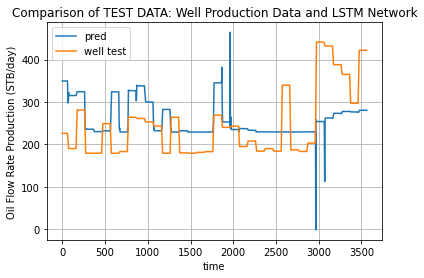

In [34]:
#df2 = pd.read_csv("upsample.csv")
#df2 = df2.iloc[:,0:152]
x2 = df['glir11'].to_numpy()[int(split*len(data)):]
y2 = df['qt11'].to_numpy()[int(split*len(data)):]

#x2 = df2['GLIR'].to_numpy()
#y2 = df2['Qo'].to_numpy()

#New dataframe with only testing data
x2 = x2.reshape(len(x2),1)
y2 = y2.reshape(len(y2),1)
df_for_testing_x = x2
df_for_testing_y = y2

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_testing_x)
scaler2 = scaler.fit(df_for_testing_y)

df_for_testing_scaled_x = scaler.transform(df_for_testing_x)
df_for_testing_scaled_y = scaler2.transform(df_for_testing_y)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for testing). 

#Empty lists to be populated using formatted testing data
testX = []
testY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_testing_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_testing_scaled_x) - n_future +1):
    testX.append(df_for_testing_scaled_x[i - n_past:i, 0:df_for_testing_x.shape[1]])

for i in range(n_past, len(df_for_testing_scaled_y) - n_future +1):
    testY.append(df_for_testing_scaled_y[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

#Make forecast
#model = keras.models.load_model("RNN_Model")

n_days_for_forecast = 20
forecast = model.predict(testX[:]) #shape = (n, 1) where n is the n_days_for_forecast

#Perform inverse transformation to rescale back to original range

forecast_copies = np.repeat(forecast, df_for_testing_y.shape[1], axis=-1)
y_fore_future = scaler.inverse_transform(forecast_copies)

#print('nilai pred:',y_fore_future)

yyy = scaler.inverse_transform(testY)

x_axis = np.arange(0,y_fore_future.shape[0])

print(f"ukuran y: {np.shape(yyy)} ukuran y pred: {np.shape(y_fore_future)}")

plt.figure(2)
plt.plot(x_axis,y_fore_future, label='pred')
plt.plot(x_axis,yyy, label='well test')
plt.title("Comparison of TEST DATA: Well Production Data and LSTM Network")
plt.xlabel("time")
plt.ylabel("Oil Flow Rate Production (STB/day)")
plt.legend()
plt.grid()
plt.show()

In [35]:
import math
from sklearn.metrics import r2_score

MSE = np.square(np.subtract(yyy,y_fore_future)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:")
print(RMSE)

r2 = r2_score(yyy,y_fore_future)
print("\nR2 Value:")
print(r2)

Root Mean Square Error:
79.52153781926593

R2 Value:
-0.058566564325541526
